# Prelims

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

import textwrap

/Users/adamschiller/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'
CSV = PATH/'words.csv'

# !ls {PATH}

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Helpers

In [5]:
def nonzero(pred):
    ints = to_np(pred).astype(int)
    return ints[np.nonzero(ints)]

def char_label_text(pred, chunk=70):
    st = ''.join([itos[i] for i in nonzero(pred)])
    return '\n'.join(textwrap.wrap(st, chunk))

def char_split_text(pred):
    return [itos[i] for i in nonzero(pred)]

def word_label_text(pred, chunk=70):
    st = ' '.join([w_itos[i] for i in nonzero(pred)])
    return '\n'.join(textwrap.wrap(st, chunk))

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    if title: ax.set_title(title)
    return ax

## Loss and Metrics

In [7]:
def loss_prep(input, target):
    "equalize input/target sl; combine bs/sl dimensions"
    bs,tsl = target.shape
    _ ,sl,vocab = input.shape
        
    # F.pad( front,back for dimensions: 1,0,2 )
    if sl>tsl: target = F.pad(target, (0,sl-tsl))
        
    # this should only be used when testing for small seq_lens
    # if tsl>sl: target = target[:,:sl]
    
    if tsl>sl: input = F.pad(input, (0,0,0,tsl-sl))
    # not ideal => adds 82 logits all 0s...
        
    targ = target.contiguous().view(-1).long()
    pred = input.contiguous().view(-1, vocab)
    return pred, targ

In [8]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        
    def forward(self, pred, target):
        pred,targ = loss_prep(pred, target)
        pred = F.log_softmax(pred, dim=-1)  # need this for KLDivLoss
        true_dist = pred.data.clone()
        true_dist.fill_(self.smoothing / pred.size(1))                  # fill with 0.0012
        true_dist.scatter_(1, targ.data.unsqueeze(1), self.confidence)  # [0.0012, 0.0012, 0.90, 0.0012]
        return F.kl_div(pred, true_dist, reduction='sum')/bs

In [9]:
def XE_loss(input, target):    # takes logits
    pred,targ = loss_prep(input, target)
    return F.cross_entropy(pred, targ, reduction='sum')/bs

In [10]:
def perplexity(input, target):
    pred,targ = loss_prep(input, target)
    return torch.exp(F.cross_entropy(pred, targ))

In [11]:
def acc(input, target):
    pred,targ = loss_prep(input, target)
    preds = torch.argmax(pred, dim=-1)
    return (preds==targ).float().mean()

In [12]:
import Levenshtein as Lev

# pulled from Sean Nareen's deepspeech decoder module
# https://github.com/SeanNaren/deepspeech.pytorch/blob/master/decoder.py

def _cer(t, p):
    """
    Computes the Character Error Rate, defined as the edit distance.
    Arguments:
        t (string): target space-separated sentence
        p (string): prediction space-separated sentence
    """
    t, p, = t.replace(' ', ''), p.replace(' ', '')
    return Lev.distance(t, p)/len(t)

def _wer(s1, s2):
    """
    Computes the Word Error Rate, defined as the edit distance between the
    two provided sentences after tokenizing to words.
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """

    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein package only accepts strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2))/len(w1)

In [13]:
def cer(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([bs, sl, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = char_label_text(res[i])
        t = char_label_text(targs[i])
        error += _cer(t,p)
    return error/bs

def wer(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([bs, sl, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = word_label_text(res[i])
        t = word_label_text(targs[i])
        error += _wer(t,p)
    return error/bs

## Stepper

In [14]:
def subsequent_mask(size):
    attn_shape = torch.ones((size,size), dtype=torch.int, device=device)
    mask = torch.tril(attn_shape).unsqueeze(0)
    return mask

def make_tgt_mask(tgt, pad=0):
    "Create a mask to hide padding and future words."
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return tgt_mask

In [15]:
def rshift(tgt, token=1):
    "Shift y to the right by prepending token"
    return torch.cat((torch.ones((tgt.size(0),token), device=device), tgt[:,:-1]), dim=-1)

In [16]:
class TfmrStepper(Stepper):
    def step(self, xs, y, epoch):
#         self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
        xtra = []
    
        shifted_y = rshift(y).long()
        tgt_mask = subsequent_mask(shifted_y.size(-1)) #make_tgt_mask(shifted_y)
        output = self.m(*xs, shifted_y, tgt_mask)
        
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()        
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm_(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.item()
    
    def evaluate(self, xs, y):
        shifted_y = rshift(y).long()
        tgt_mask = subsequent_mask(shifted_y.size(-1)) #make_tgt_mask(shifted_y)
        preds = self.m(*xs, shifted_y, tgt_mask)
        if isinstance(preds,tuple): preds=preds[0]
        return preds, self.crit(preds, y)

# Data

In [29]:
fname = 'synth_words_50000.csv' if device.type == 'cuda' else 'synth_words.csv'
CSV = PATH/fname
FOLDER = 'synth_words'

csv = pd.read_csv(CSV)
len(csv)

10000

In [30]:
sz,bs = 128,100  #256,60  #128,100
seq_len = 45
stats = (np.array([0.90382, 0.90382, 0.90382]), np.array([0.19798, 0.19798, 0.19798]))  # inception_stats

## ModelData

In [31]:
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))

val_idxs = np.array(csv.sample(frac=0.15, random_state=42).index)

f = resnet34

In [32]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]
# tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, FOLDER, CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)

In [33]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

### Verify Data

In [22]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.trn_dl))
# imgs = denorm(x)

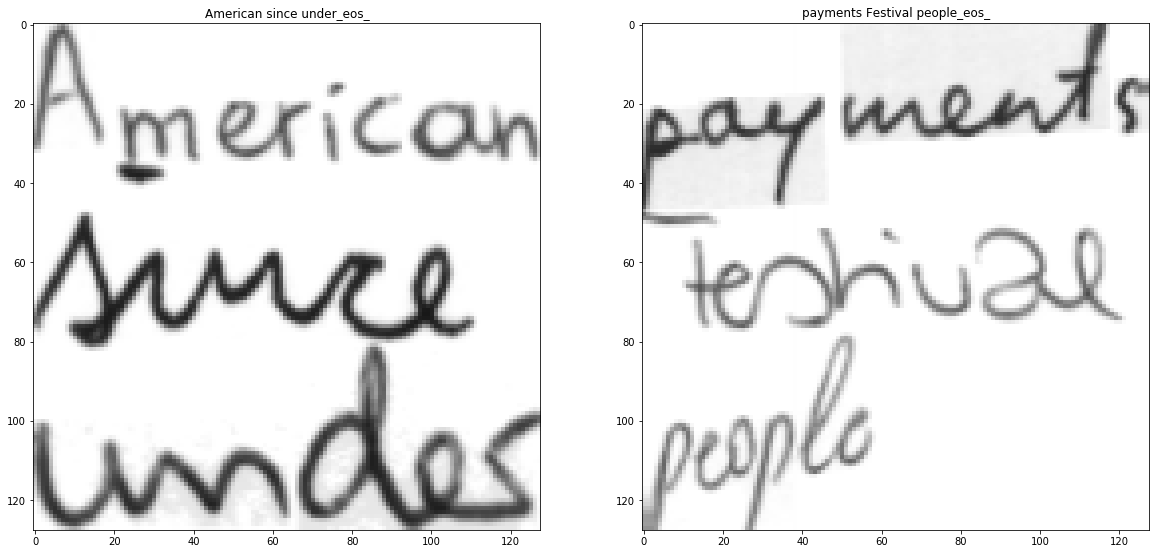

In [23]:
fig, axes = plt.subplots(1,2, gridspec_kw={'hspace': 0.3}, figsize=(20, 10))
for i,ax in enumerate(axes.flat):
    t = char_label_text(y[i])
    ax=show_img(denorm(x[i])[0], ax=ax, title=t)

# Transformer Modules

In [34]:
# similar to batchnorm but on a layer level
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [35]:
class SublayerConnection(nn.Module):
    "A residual connection followed by a layer norm.  Note: (for code simplicity) norm is first."
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [36]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [37]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

In [38]:
class EncoderLayer(nn.Module):
    "Encoder: self-attn and feed forward"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)

    def forward(self, x):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x))
        return self.sublayer[1](x, self.feed_forward)

In [39]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, src, tgt_mask=None):
        for layer in self.layers:
            x = layer(x, src, tgt_mask)
        return self.norm(x)

In [40]:
class DecoderLayer(nn.Module):
    "Decoder: self-attn, src-attn, and feed forward"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)  # wraps layer in residual,dropout,norm
 
    def forward(self, x, src, tgt_mask=None):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, src, src))
        return self.sublayer[2](x, self.feed_forward)

In [41]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    depth = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(depth)  #(bs, sl, hw)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)    
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn   #(bs, sl, d_model)

In [42]:
class SingleHeadedAttention(nn.Module):
    def __init__(self, d_model, dropout=0.2):
        super(SingleHeadedAttention, self).__init__()
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, mask=None):        
        query, key, value = [l(x) for l, x in zip(self.linears, (query, key, value))]
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        return self.linears[-1](x)

In [43]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, d_model, h=1, dropout=0.2):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h        # assume d_v always equals d_k
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask=None):
        if mask is not None: mask = mask.unsqueeze(1)
        bs = q.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        q, k, v = [l(x).view(bs, -1, self.h, self.d_k).transpose(1,2) for l, x in zip(self.linears, (q, k, v))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(q, k, v, mask=mask, dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(bs, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [44]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, dropout=0.2):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_model*4)
        self.w_2 = nn.Linear(d_model*4, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [45]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=2000):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0.0, max_len).unsqueeze(1)
        log_increment = math.log(1e4) / d_model
        div_term = torch.exp(torch.arange(0.0, d_model, 2) * -log_increment)  
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe.unsqueeze_(0)

        self.register_buffer('pe', pe)    #(1,max_len,d_model)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

In [46]:
class ResnetBase(nn.Module):
    def __init__(self, em_sz):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[em_sz]
        
        net = f(True)
        modules = list(net.children())[:s]
        self.base = nn.Sequential(*modules)
        
    def forward(self, x):
        return self.base(x)

# Full Arch

In [38]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, tgt_mask=None):
        return self.decode(self.encode(src), tgt, tgt_mask)
    
    def encode(self, src):
        return self.encoder(src)
    
    def decode(self, src, tgt, tgt_mask=None):
        return self.decoder(self.tgt_embed(tgt), src, tgt_mask)
    
    def generate(self, outs):
        return self.generator(outs)

In [39]:
class ResnetBase(nn.Module):
    def __init__(self, em_sz, d_model):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[em_sz]
        
        net = f(True)
        modules = list(net.children())[:s]
        self.base = nn.Sequential(*modules)
        self.linear = nn.Linear(em_sz, d_model)
        
    def forward(self, x):
        x = self.base(x).flatten(2,3).permute(0,2,1)
        x = self.linear(x) * math.sqrt(self.linear.out_features)
        return x

In [40]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [41]:
def make_full_model(vocab, d_model=512, N=4, drops={'attn':0.2, 'ff':0.2, 'pos':0.2, 'layer':0.2}):
    c = copy.deepcopy
    attn = SingleHeadedAttention(d_model)
    ff = PositionwiseFeedForward(d_model, drops['ff'])

    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), drops['layer']), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), drops['layer']), N),
        nn.Sequential(
            Embeddings(d_model, vocab), PositionalEncoding(d_model, 1, drops['pos'], 5000)
        ),
        nn.Linear(d_model, vocab)
    )
        
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
                    
    return model

In [42]:
class Img2Seq(nn.Module):
    def __init__(self, img_encoder, transformer):
        super(Img2Seq, self).__init__()
        self.img_enc = img_encoder
        self.transformer = transformer
        
    def forward(self, src, tgt=None, tgt_mask=None):
        feats = self.img_enc(src)                            # ([bs, h*w, d_model])
        dec_outs = self.transformer(feats, tgt, tgt_mask)    # ([bs, sl, d_model])
        out = self.transformer.generate(dec_outs)            # ([bs, sl, vocab])
        return out

    def greedy_decode(self, src, seq_len):
        with torch.no_grad():
            feats = self.transformer.encode(self.img_enc(src))
            bs = src.size(0)
            tgt = torch.ones((bs,1), dtype=torch.long, device=device)

            res = []                
            for i in tqdm(range(seq_len)):
                dec_outs = self.transformer.decode(feats, Variable(tgt))
                prob = self.transformer.generate(dec_outs[:,-1])
                res.append(prob)
                pred = torch.argmax(prob, dim=-1, keepdim=True)
                if (pred==0).all(): break
                tgt = torch.cat([tgt,pred], dim=-1)
            out = torch.stack(res).transpose(1,0).contiguous()
            return out      

In [43]:
d_model = 512
em_sz = 256
img_encoder = ResnetBase(em_sz, d_model)
transformer = make_full_model(len(itos), d_model)
net = Img2Seq(img_encoder, transformer)

opt_fn = partial(optim.Adam, betas=(0.7, 0.99)) #, lr=0, betas=(0.9, 0.98), eps=1e-9)
# partial: way to always call a function with a given set of arguments or keywords

learn = RNN_Learner(data, BasicModel(to_gpu(net)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = LabelSmoothing(smoothing=0.1)   #XE_loss
learn.metrics = [cer]

# Experimental Full Arch

In [47]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, tgt_mask=None):        
        return self.decode(self.encode(src), tgt, tgt_mask)
    
    def encode(self, src):
        return self.encoder(self.src_embed(src))
    
    def decode(self, src, tgt, tgt_mask=None):
        return self.decoder(self.tgt_embed(tgt), src, tgt_mask)
    
    def generate(self, outs):
        return self.generator(outs)

In [63]:
#experiment
#128: 3x7, 21
#256: 7x15, 105
#512: 15x31, 465
#1024: 31x63, 1953

class ImageAdaptor(nn.Module):
    def __init__(self, em_sz, d_model, drop=0.2):
        super().__init__()
        
        pool_size = (3,15) #3x1  (3,25) #3x2
        
        self.d_model = d_model
        # try this on monday
        # self.c0 = nn.Conv2d(em_sz, d_model, (4,2), (2,1))  

        # try this on monday
        self.pool = AdaptiveConcatPool2d(pool_size)
        self.linear = nn.Linear(d_model, d_model)
                
    def forward(self, x):
        # x = self.c0(x).flatten(2,3).permute(0,2,1) * 4
        x = self.linear(self.pool(x).flatten(2,3).permute(0,2,1)) * 3
        return x

In [61]:
# class ImageAdaptor(nn.Module):
#     def __init__(self, em_sz, d_model, drop=0.2):
#         super().__init__()
        
#         self.d_model = d_model
#         self.linear = nn.Linear(em_sz, d_model)
#         self.dropout = nn.Dropout(drop)
        
#     def forward(self, x):        
#         x = x.flatten(2,3).permute(0,2,1)
#         x = self.linear(x) * 4   #adjust the std to ~1
#         return self.dropout(x)

In [53]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * 18  #math.sqrt(self.d_model)

In [39]:
# allows decoder to bypass the masking of targets????

class SeparableConv(nn.Module):
    def __init__(self,c_in,c_out,k=3,stride=1,padding=1,dilation=1,bias=False):
        super(SeparableConv,self).__init__()

        self.depthwise = nn.Conv1d(c_in,c_in,k,stride,padding,dilation,groups=c_in,bias=bias)
        self.pointwise = nn.Conv1d(c_in,c_out,1,1,0,1,1,bias=bias)

    def forward(self,x):
        x = x.permute(0,2,1)
        x = self.depthwise(x)   # maps cross channel correlations
        x = self.pointwise(x)   # maps spatial correlations of each channel
        return x.permute(0,2,1)

In [50]:
def make_full_model(vocab, em_sz=256, d_model=512, N=4, drop=0.2):
    c = copy.deepcopy
    attn = SingleHeadedAttention(d_model)
#     attn = MultiHeadedAttention(d_model, h=8)
    ff = PositionwiseFeedForward(d_model, drop)
#     sc = SeparableConv(d_model, d_model)

    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), drop), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), drop), N),
        nn.Sequential(
            ImageAdaptor(em_sz, d_model), PositionalEncoding(d_model, drop, 2000)
        ),
        nn.Sequential(
            Embeddings(d_model, vocab), PositionalEncoding(d_model, drop, 2000)
        ),
        nn.Linear(d_model, vocab)
    )
        
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
                    
    return model

In [51]:
class Img2Seq(nn.Module):
    def __init__(self, img_encoder, transformer):
        super(Img2Seq, self).__init__()
        self.img_enc = img_encoder
        self.transformer = transformer
        
    def forward(self, src, tgt=None, tgt_mask=None):
        feats = self.img_enc(src)                            # ([bs, h*w, d_model])
        dec_outs = self.transformer(feats, tgt, tgt_mask)    # ([bs, sl, d_model])
        out = self.transformer.generate(dec_outs)            # ([bs, sl, vocab])
        return out
    
#     def forward(self, src):
#         feats = self.transformer.encode(self.img_enc(src))
#         bs = src.size(0)
#         tgt = torch.ones((bs,seq_len), dtype=torch.long, device=device)
#         mask = subsequent_mask(tgt.size(-1))

#         res = []
#         for i in range(seq_len):
#             dec_outs = self.transformer.decode(feats, Variable(tgt), mask)
#             prob = self.transformer.generate(dec_outs[:,i])
#             res.append(prob)
#             pred = torch.argmax(prob, dim=-1)
#             if (pred==0).all().item(): break
#             tgt[:,i+1] = pred
# #             tgt = torch.cat([tgt,pred], dim=-1)
#         out = torch.stack(res).transpose(1,0).contiguous()
#         return out
    
    def greedy_decode(self, src, seq_len):
        with torch.no_grad():
            feats = self.transformer.encode(self.img_enc(src))
            bs = src.size(0)
            tgt = torch.ones((bs,1), dtype=torch.long, device=device)

            res = []                
            for i in tqdm(range(seq_len)):
                dec_outs = self.transformer.decode(feats, Variable(tgt))
                prob = self.transformer.generate(dec_outs[:,-1])
                res.append(prob)
                pred = torch.argmax(prob, dim=-1, keepdim=True)
                if (pred==0).all().item(): break
                tgt = torch.cat([tgt,pred], dim=-1)
            out = torch.stack(res).transpose(1,0).contiguous()
            return out      

In [61]:
d_model = 512
em_sz = 256
img_encoder = ResnetBase(em_sz)
transformer = make_full_model(len(itos), em_sz, d_model, 4)
net = Img2Seq(img_encoder, transformer)

opt_fn = partial(optim.Adam, betas=(0.7, 0.99)) #, lr=0, betas=(0.9, 0.98), eps=1e-9)
# partial: way to always call a function with a given set of arguments or keywords

learn = RNN_Learner(data, BasicModel(to_gpu(net)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = LabelSmoothing(smoothing=0.1)   #XE_loss
learn.metrics = [cer, acc]

# Positional Arch

In [36]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, tgt_mask=None):
        return self.decode(self.encode(src), tgt, tgt_mask)
    
    def encode(self, src):
        return self.encoder(self.src_embed(src))
    
    def decode(self, src, tgt, tgt_mask=None):
        return self.decoder(self.tgt_embed(tgt), src, tgt_mask)
    
    def generate(self, outs):
        return self.generator(outs)

In [38]:
class ImageAdaptor(nn.Module):
    def __init__(self, em_sz, d_model, drop=0.1):
        super().__init__()
        
        self.adaptor = nn.Sequential(
            nn.Conv2d(em_sz, d_model, 1),
            nn.BatchNorm2d(d_model)
        )
        self.pos_enc = PositionalEncoding(d_model, dims=2)
        self.dropout = nn.Dropout(drop)
        
    def forward(self, x):
        x = self.adaptor(x).permute(0,2,3,1)         # bs,h,w,d_model
        x = self.pos_enc(x)
        x = x.flatten(1,2).contiguous()
        x = self.dropout(x)
        return x

In [39]:
class PosEncInputs(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        
        self.d_model = d_model
        
    def forward(self, tgt):
        bs,sl = tgt.shape
        return torch.zeros((bs,sl,self.d_model), device=device)

In [40]:
def make_full_model(vocab, em_sz=256, d_model=512, N=4, drop=0.2):
    c = copy.deepcopy
#     attn = MultiHeadedAttention(d_model, 4)
    attn = SingleHeadedAttention(d_model)
    ff = PositionwiseFeedForward(d_model, drop)

    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), drop), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), drop), N),
        ImageAdaptor(em_sz, d_model, drop=0.1),
        nn.Sequential(
            PosEncInputs(d_model),
#             nn.Embedding(vocab, d_model),
            PositionalEncoding(d_model, dims=1),
            nn.Dropout(0.1)
        ),
        nn.Sequential(
            nn.Linear(d_model, vocab),
        )
    )
        
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
            
    return model

In [41]:
class Img2Seq(nn.Module):
    def __init__(self, img_enc, transformer):
        super(Img2Seq, self).__init__()
        self.img_enc = img_enc
        self.transformer = transformer
        
    def forward(self, src, tgt=None, tgt_mask=None):        
        feats = self.img_enc(src)
        dec_outs = self.transformer(feats, tgt, tgt_mask)      # ([bs, sl, d_model])
        out = self.transformer.generate(dec_outs)              # ([bs, sl, vocab])
        return out

    
    # paper: beam search with a beam size of 4 and length penalty α = 0.6
    def greedy_decode(self, src, seq_len):
        with torch.no_grad():
            feats = self.transformer.encode(self.img_enc(src))
            bs = src.size(0)
            tgt = torch.ones((bs,1), dtype=torch.long, device=device)

            res = []                
            for i in tqdm(range(seq_len)):
                dec_outs = self.transformer.decode(feats, Variable(tgt))
                prob = self.transformer.generate(dec_outs[:,-1])
                res.append(prob)
                pred = torch.argmax(prob, dim=-1, keepdim=True)
                if (pred==0).all(): break
                tgt = torch.cat([tgt,pred], dim=-1)
            out = torch.stack(res).transpose(1,0).contiguous()
            return out      

In [42]:
em_sz = 256
d_model = 512
transformer = make_full_model(len(itos), em_sz, d_model)
img_enc = ResnetBase(em_sz)
net = Img2Seq(img_enc, transformer)

opt_fn = partial(optim.Adam, betas=(0.7, 0.99)) #, lr=0, betas=(0.9, 0.98), eps=1e-9)
# partial: way to always call a function with a given set of arguments or keywords

learn = RNN_Learner(data, BasicModel(to_gpu(net)), opt_fn=opt_fn)
# learn.clip = 0.25
learn.crit = LabelSmoothing(smoothing=0.1)   #XE_loss
learn.metrics = [cer, acc]

# Experiment

In [62]:
lr=1e-4
learn.fit(lr, 10, cycle_len=1, stepper=TfmrStepper, use_clr=(20,10))

# sz: 128
# input: 3x1
# 7.298699   7.093821   0.091642   0.936467    BASELINE - Full tfmr   ~29m
# 12.632411  11.250037  0.146551   0.897713    adaptor: linear + drop, no scaling
# 7.696308   7.444015   0.092946   0.935293    adaptor: linear + drop, variable scaling (mean: ~0, std: ~1.3)
# 7.895011   7.328106   0.091981   0.936015  **adaptor: linear + drop, variable scaling (mean: ~0, std: ~1.0)
# 12.254474  10.917412  0.141336   0.900215    adaptor: conv/bn + drop, no scaling
# 8.278391   7.641951   0.093473   0.934648    adaptor: conv/bn + drop, variable scaling (mean: ~0, std: ~1.0)

# 7.781198   7.318005   0.092242   0.936243    tgt_embed: concat
# 7.937731   7.454437   0.096227   0.934018    tgt_embed: concat (half padding)
# 7.945669   7.453154   0.095435   0.934268    tgt_embed: alternate (expand+concat, 128)

# 8.115278   7.623288   0.093808   0.93466     src_embed: alternate/2, tgt_embed: alternate
# 8.520103   7.76069    0.096197   0.932976    src_embed: sin/cos halves

# 7.382526   7.037988   0.086177   0.939925    6layers, 8head multi attn
# 8.146375   7.758409   0.095613   0.933915    src_embed: 1d pos_enc after adaptor
# 13.758293  11.456147  0.157607   0.894404    inception-resnetv2
# 9.080251   8.251486   0.102321   0.928775    2layers, single attn

# 8.010308   7.639033   0.093939   0.934245    multi conv+concat adaptor     exp_1
# 7.936379   7.447648   0.093064   0.93505     "", w/ pos_enc     exp_2

# 7.940702   7.487757   0.093914   0.934856    separable conv instead of ff (only encoder)

  0%|          | 0/85 [00:00<?, ?it/s]> <ipython-input-60-6d4094bc1cf2>(26)forward()
-> return x
(Pdb) x.shape
torch.Size([2304000])
(Pdb) x.mean()
tensor(0.0002, grad_fn=<MeanBackward1>)
(Pdb) x.std()
tensor(0.3988, grad_fn=<StdBackward0>)
(Pdb) (x * 3).std()
tensor(1.1965, grad_fn=<StdBackward0>)
(Pdb) q


BdbQuit: 

In [64]:
learn.save('exp_3')

### Decode Stats

In [65]:
v_dl = iter(data.val_dl)
denorm = data.val_ds.denorm

In [66]:
x,y = next(v_dl)
# imgs = denorm(x)

shifted_y = rshift(y).long()
tgt_mask = subsequent_mask(shifted_y.size(-1)) #make_tgt_mask(shifted_y)

learn.model.eval()

v_preds = learn.model(x, shifted_y, tgt_mask)
v_res = torch.argmax(v_preds, dim=-1)
# v_attn = source_attn()

g_preds = learn.model.greedy_decode(x, seq_len)
g_res = torch.argmax(g_preds, dim=-1)
# g_attn = source_attn()

 60%|██████    | 27/45 [00:01<00:00, 20.62it/s]


In [67]:
v = [learn.crit(v_preds, y).item(), cer(v_preds, y), acc(v_preds, y).item()]
print(f'valid:     {str(v[0])[:7]}   {str(v[1])[:7]}   {str(v[2])[:7]}')

g = [learn.crit(g_preds, y).item(), cer(g_preds, y), acc(g_preds, y).item()]
print(f'greedy:    {str(g[0])[:7]}   {str(g[1])[:7]}   {str(g[2])[:7]}')

valid:     7.02789   0.08808   0.93387
greedy:    41.9441   0.10676   0.77000


In [ ]:
# 3x1, 128/100
#             loss       cer        acc
# valid:     6.55702   0.08746   0.93483   BASELINE - Full tfmr
# greedy:    42.5730   0.10094   0.75906

# valid:     6.93387   0.08971   0.93781   adaptor: linear + drop, variable scaling (mean: ~0, std: ~1.3)
# greedy:    39.4327   0.09789   0.79093

# valid:     6.93380   0.08312   0.93612 **adaptor: linear + drop, variable scaling (mean: ~0, std: ~1.0)
# greedy:    37.0399   0.09706   0.80000

# valid:     7.29669   0.08913   0.93387   adaptor: conv/bn + drop, variable scaling (mean: ~0, std: ~1.0)
# greedy:    44.4624   0.10627   0.74387
    
# valid:     6.72405   0.08418   0.93612   tgt_embed: concat
# greedy:    45.0124   0.09824   0.76161

# valid:     6.83794   0.08125   0.94032   tgt_embed: concat (half padding)
# greedy:    43.0944   0.10266   0.75967

# valid:     7.02934   0.08462   0.93516   tgt_embed: alternate (expand+concat, 128)
# greedy:    52.7249   0.11374   0.71580

# valid:     7.40092   0.09333   0.93064   src_embed: alternate/2, tgt_embed: alternate
# greedy:    43.2047   0.11189   0.74516

# valid:     7.35582   0.08943   0.93258   src_embed: sin/cos halves
# greedy:    46.8278   0.11176   0.74580

# valid:     6.58794   0.08054   0.94032   6layers, 8heads  --  best validation, worst greedy decoding performance!!
# greedy:    54.4169   0.16981   0.68970

# valid:     7.80512   0.09917   0.92387   2layers, single attn
# greedy:    47.7390   0.11607   0.73774

# valid:     7.19061   0.09251   0.93258   src_embed: 1d pos_enc after adaptor
# greedy:    44.4029   0.11210   0.75363

# valid:     10.7449   0.14645   0.89612   inception_resnetv2
# greedy:    60.8683   0.19089   0.65419

# valid:     7.17454   0.09311   0.93000   multi conv+concat adaptor
# greedy:    42.5465   0.11502   0.75032
    
# valid:     6.95771   0.08687   0.93419   "", w/ pos_enc
# greedy:    44.8684   0.10522   0.76129

# valid:     7.02789   0.08808   0.93387   separable conv instead of ff (only encoder)
# greedy:    41.9441   0.10676   0.77000


    
# previous best models - tfmr full
#             loss       cer        acc
# valid:     2.42856   0.02981   0.98177   3x1, 256/60, 'tfmr_full_3x1_single_attn'
# greedy:    11.9438   0.02745   0.93385

# valid:     1.47604   0.00797   0.99523   3x2, 400/45,  'tfmr_full_3x2'
# greedy:    21.4682   0.01097   0.93762

# valid:     7.30494   0.01206   0.99086   lg,  512,30,  'tfmr_full_lg'
# greedy:    866.544   0.14109   0.37214

# valid:     10.1481   0.00501   0.99602   cat9-12,  800/8,  'tfmr_cat9-12_full_800'
# greedy:    1330.63   0.04525   0.53181

# valid:     50.1414   0.04137   0.97004   pg,  1000/5,  'tfmr_pg_1000'
# greedy:    2579.24   0.34178   0.18623

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


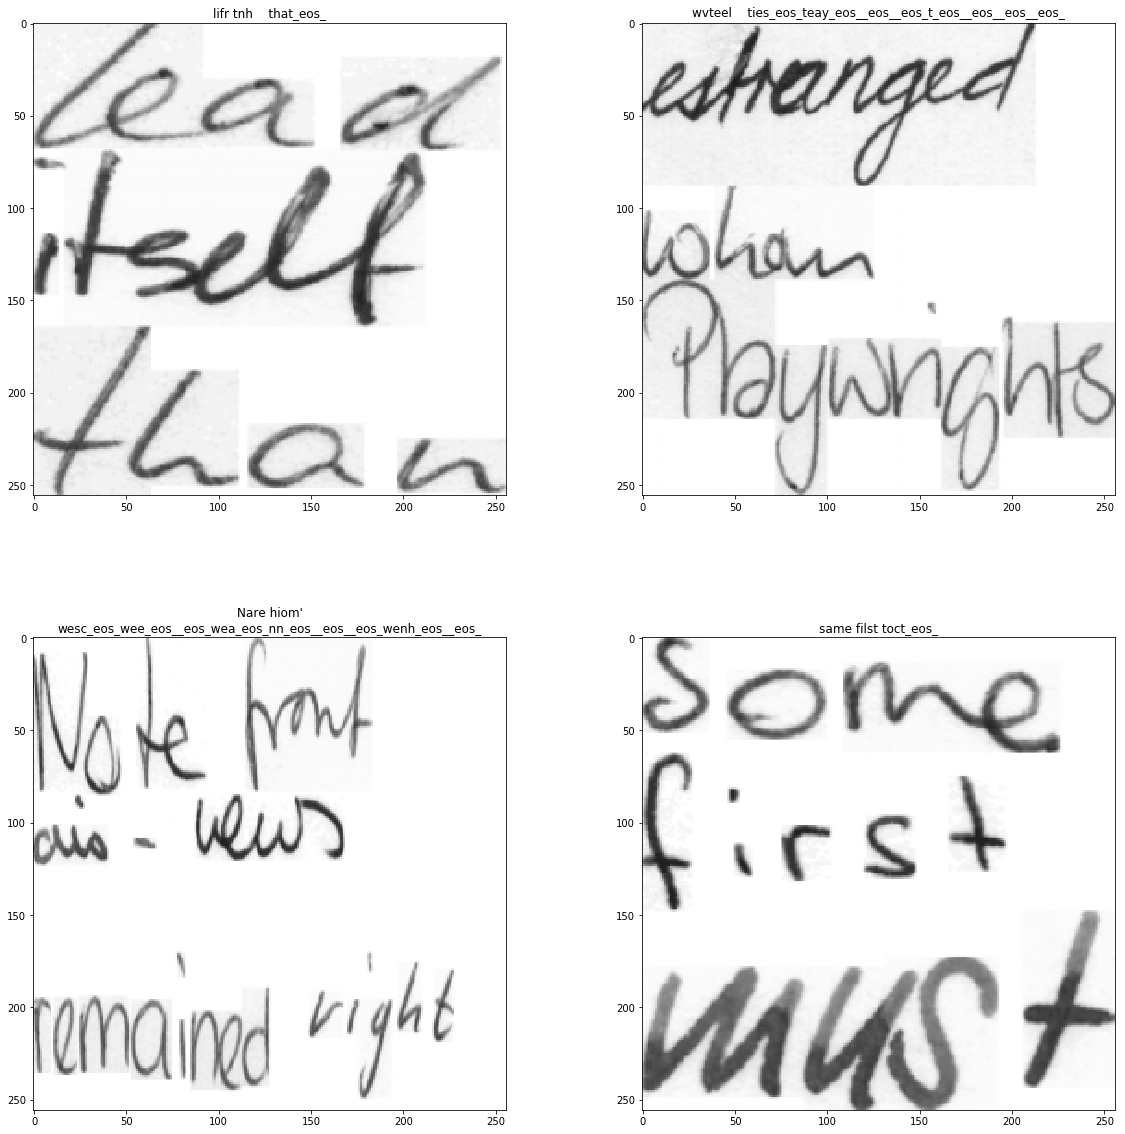

In [58]:
# res = torch.argmax(preds, dim=-1)
denorm = data.val_ds.denorm

fig, axes = plt.subplots(2,2, gridspec_kw={'hspace': 0.3}, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    t = char_label_text(res[i])
    ax=show_img(denorm(x[i])[0], ax=ax, title=t)

# Test

In [44]:
from scipy.ndimage import gaussian_filter
k=16

def torch_scale_attns(attns):
    bs,sl,hw = attns.shape
    num = int(math.sqrt(hw))   # sz // k
    mod = attns.view(bs,sl,num,num)
    scaled = F.interpolate(mod, size=sz)
    return scaled  #([bs, sl, h, w])

def g_filter(att):
    return gaussian_filter(att, sigma=k)

In [45]:
def self_attn(layer=-1): return learn.model.transformer.decoder.layers[layer].self_attn.attn.data
def source_attn(layer=-1): return learn.model.transformer.decoder.layers[layer].src_attn.attn.data

In [69]:
learn.load('tfmr_pg_1000')

In [70]:
v_dl = iter(data.val_dl)
denorm = data.val_ds.denorm

## Results

In [71]:
x,y = next(v_dl)
imgs = denorm(x)

shifted_y = rshift(y).long()
tgt_mask = subsequent_mask(shifted_y.size(-1)) #make_tgt_mask(shifted_y)

learn.model.eval()

v_preds = learn.model(x, shifted_y, tgt_mask)
v_res = torch.argmax(v_preds, dim=-1)
v_attn = source_attn()

g_preds = learn.model.greedy_decode(x, seq_len)
g_res = torch.argmax(g_preds, dim=-1)
g_attn = source_attn()

 67%|██████▋   | 469/700 [00:19<00:09, 24.41it/s]

In [72]:
v = [learn.crit(v_preds, y).item(), cer(v_preds, y), acc(v_preds, y).item()]
print(f'valid:     {str(v[0])[:7]}   {str(v[1])[:7]}   {str(v[2])[:7]}')

g = [learn.crit(g_preds, y).item(), cer(g_preds, y), acc(g_preds, y).item()]
print(f'greedy:    {str(g[0])[:7]}   {str(g[1])[:7]}   {str(g[2])[:7]}')

valid:     50.1414   0.04137   0.97004
greedy:    2579.24   0.34178   0.18623


In [ ]:
# tfmr full
#             loss       cer       acc
# valid:     2.42856   0.02981   0.98177   3x1, 256/60, 'tfmr_full_3x1_single_attn'
# greedy:    11.9438   0.02745   0.93385

# valid:     1.47604   0.00797   0.99523   3x2, 400/45,  'tfmr_full_3x2'
# greedy:    21.4682   0.01097   0.93762

# valid:     7.30494   0.01206   0.99086   lg,  512/30,  'tfmr_full_lg'
# greedy:    866.544   0.14109   0.37214

# valid:     10.1481   0.00501   0.99602   cat9-12,  800/8,  'tfmr_cat9-12_full_800'
# greedy:    1330.63   0.04525   0.53181

# valid:     50.1414   0.04137   0.97004   pg,  1000/5,  'tfmr_pg_1000'
# greedy:    2579.24   0.34178   0.18623

## 3x1 256

### Images

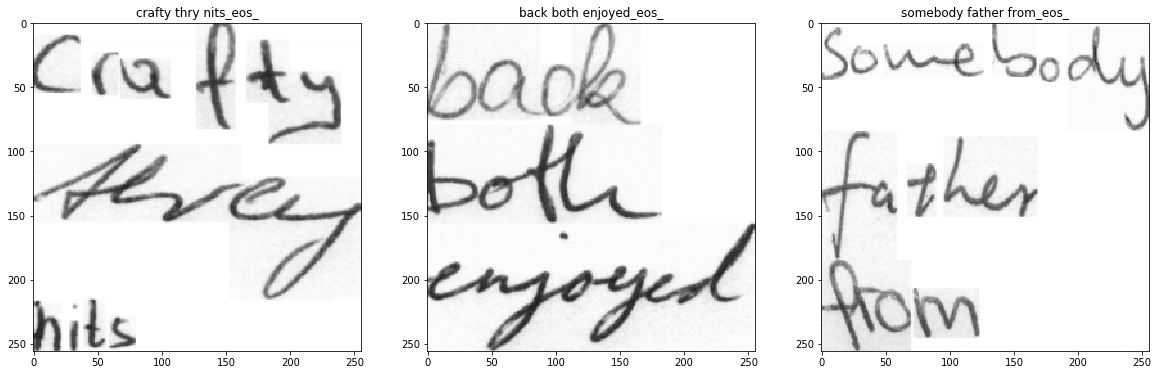

In [69]:
#valid
fig, axes = plt.subplots(1,3, gridspec_kw={'hspace': 0.4}, figsize=(20, 10))
for i,ax in enumerate(axes.flat):
    p = char_label_text(v_res[i])
    ax=show_img(imgs[i], ax=ax, title=p)

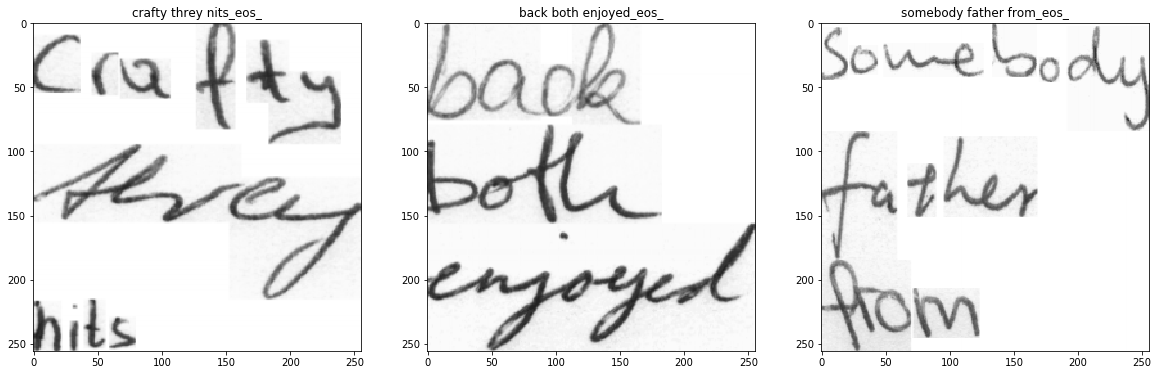

In [70]:
#greedy
fig, axes = plt.subplots(1,3, gridspec_kw={'hspace': 0.4}, figsize=(20, 10))
for i,ax in enumerate(axes.flat):
    p = char_label_text(g_res[i])
    ax=show_img(imgs[i], ax=ax, title=p)

### Source Attn

In [71]:
idx = 1
img = imgs[idx]

v_chars = v_res[idx]
v_attns = to_np(torch_scale_attns(v_attn)[idx])

g_chars = g_res[idx]
g_attns = to_np(torch_scale_attns(g_attn)[idx])

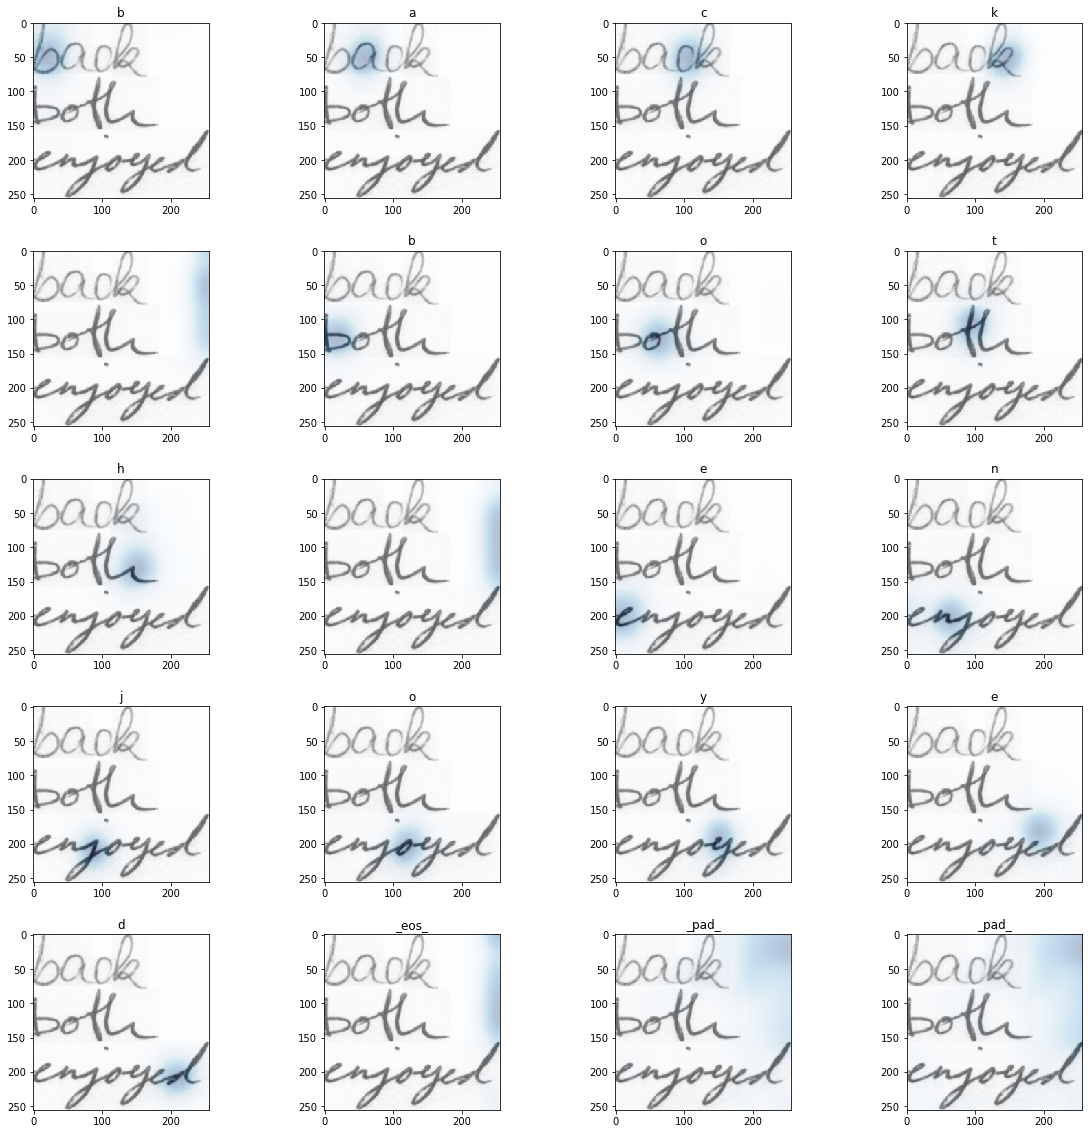

In [76]:
#valid
fig, axes = plt.subplots(5,4, gridspec_kw={'hspace': 0.3}, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    a = g_filter(v_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    ax.set_title(itos[v_chars[i].item()])

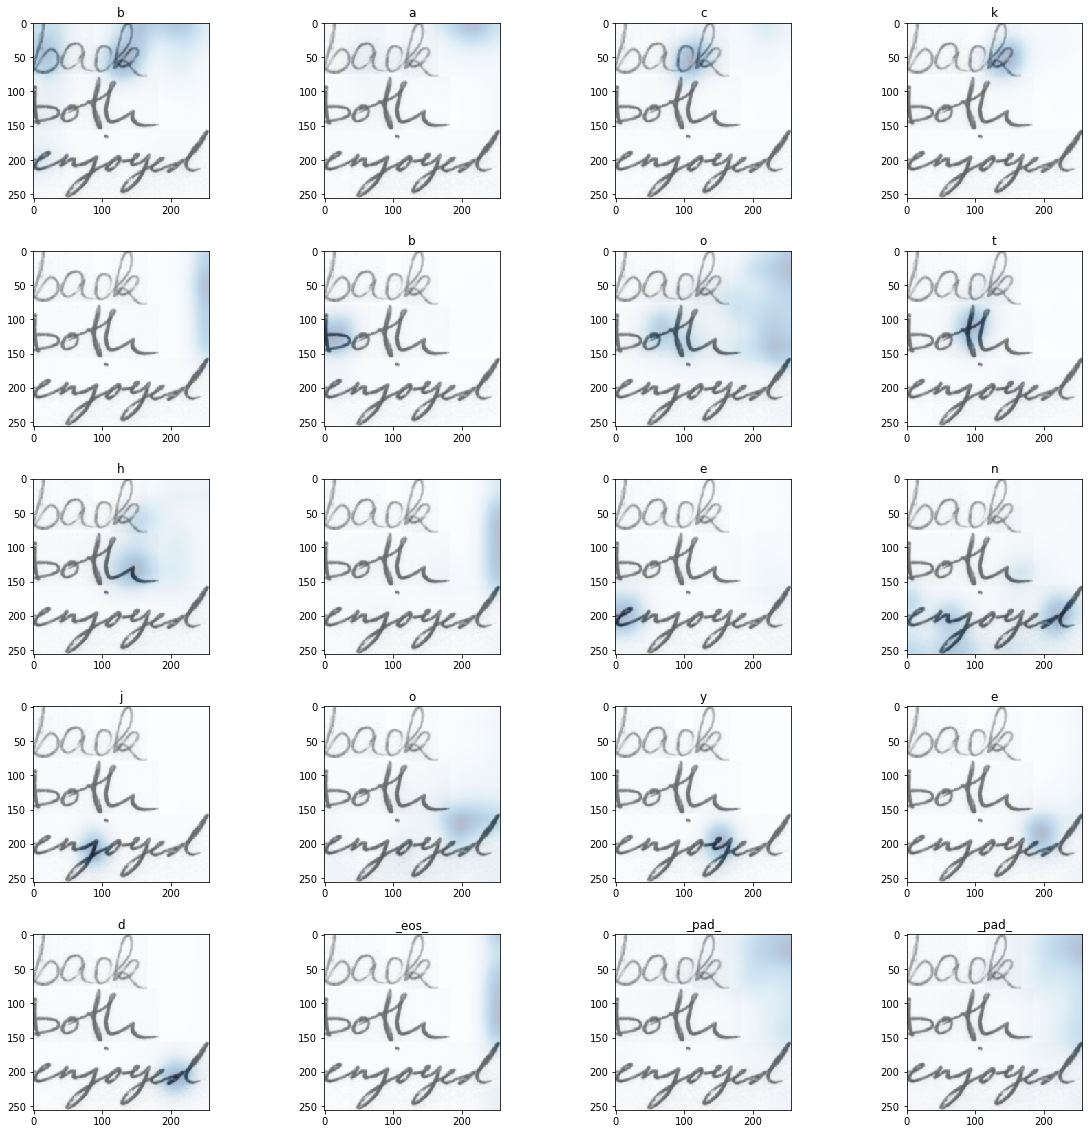

In [77]:
#greedy
fig, axes = plt.subplots(5,4, gridspec_kw={'hspace': 0.3}, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    a = g_filter(g_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    ax.set_title(itos[g_chars[i].item()])

In [56]:
# https://geekyisawesome.blogspot.com/2016/10/using-beam-search-to-generate-most.html

import heapq

class Beam(object):
    '''
    For comparison of prefixes, the tuple (prefix_probability, complete_sentence) is used.
    This is so that if two prefixes have equal probabilities then a complete sentence
    is preferred over an incomplete one since (0.5, False) < (0.5, True)
    '''

    def __init__(self, beam_width):
        self.heap = list()
        self.beam_width = beam_width

    def add(self, prob, complete, prefix):
        heapq.heappush(self.heap, (prob, complete, prefix))
        if len(self.heap) > self.beam_width:
            heapq.heappop(self.heap)
    
    def __iter__(self):
        return iter(self.heap)

In [57]:
def beamsearch(probabilities_function, beam_width=10, clip_len=-1, start_tok=1, end_tok=0):
    prev_beam = Beam(beam_width)
    prev_beam.add(1.0, False, [ start_tok ])
    while True:
        curr_beam = Beam(beam_width)
        
        #Add complete sentences that do not yet have the best probability to the current beam,
        #the rest prepare to add more words to them.
        for (prefix_prob, complete, prefix) in prev_beam:
            if complete == True:
                curr_beam.add(prefix_prob, True, prefix)
            else:
                #Get probability of each possible next word for the incomplete prefix.
                for (next_prob, next_word) in probabilities_function(prefix):
                    if next_word == end_tok:
                        #if next word is the end token then mark prefix as complete and leave out the end token
                        curr_beam.add(prefix_prob*next_prob, True, prefix)
                    else: 
                        #if next word is a non-end token then mark prefix as incomplete
                        curr_beam.add(prefix_prob*next_prob, False, prefix+[next_word])
        
        (best_prob, best_complete, best_prefix) = max(curr_beam)
        if best_complete == True or len(best_prefix)-1 == clip_len:
            #if most probable prefix is a complete sentence or has a length that exceeds 
            #the clip length (ignoring the start token) then return it
            return (best_prefix[1:], best_prob)
            #return best sentence without the start token and together with its probability
            
        prev_beam = curr_beam

In [61]:
def beam_decode(net, src, beam_width, seq_len):
    with torch.no_grad():
        feats = net.transformer.encode(net.img_enc(src))        
        gold, score = beamsearch(partial(prob_func, net=net, feats=feats, beam_width=beam_width), beam_width, seq_len)
        return gold
    
def prob_func(tgt, net=None, feats=None, beam_width=10):
    tgt = torch.tensor([tgt], dtype=torch.long, device=device)
    dec_outs = net.transformer.decode(feats, Variable(tgt))
    logits = net.transformer.generate(dec_outs[:,-1])
    res = torch.topk(F.softmax(logits, -1), beam_width, dim=-1)
    return zip(res[0][0].detach(),res[1][0].detach())

In [62]:
b_res = beam_decode(learn.model, x[0][None], 5, seq_len)
# pg, seq_len: 700, bs: 1, gpu  ~25.5s

In [ ]:
st = ''.join([itos[i] for i in b_res])
p = '\n'.join(textwrap.wrap(st, 70))
show_img(denorm(x[0][None])[0], figsize=(10,10), title=p)

In [55]:
# greedy
test_accuracy(res[0][None], y[0][None])

tensor(0.2510, device='cuda:0')

In [66]:
# beam
r = torch.tensor([b_res], dtype=torch.long, device=device)
test_accuracy(r, y[0][None])

tensor(0.2530, device='cuda:0')